# Acrobot- Boltzmann Policy

Times over -100: 404


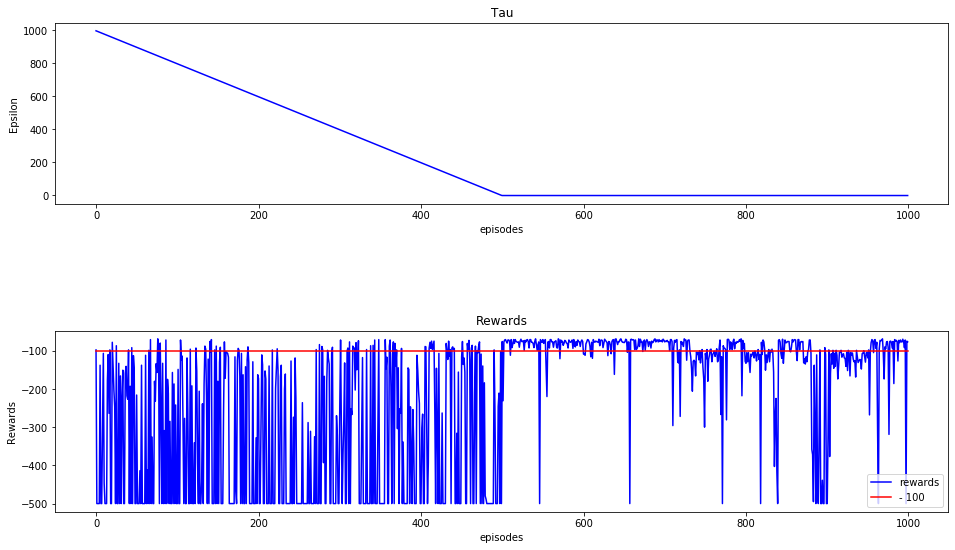

In [3]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
env = gym.make('Acrobot-v1')
import random
'''------------------------------------STATES--------------------------------------'''
#print(env.observation_space.high[0]) # 1  cos of first rotational joint 
#print(env.observation_space.high[1])  # 1 sin of first rotational joint
#print(env.observation_space.high[2])  # 1 cos of first rotational joint
#print(env.observation_space.high[3])  # 1 sin of first rotational joint
#print(env.observation_space.high[4])  # 12.566371 angular velocity of 1st joint
#print(env.observation_space.high[5])  # 28.274334 angular velocity of 2nd joint

#print('states low value:')
#print(env.observation_space.low[0])   #-4.8
#print(env.observation_space.low[1])  #-3.4028235e+38
#print(env.observation_space.low[2])  #-0.41887903
#print(env.observation_space.low[3])  #-3.4028235e+38
#print(env.observation_space.low[4])
#print(env.observation_space.low[5])
#[cos(theta1), sin(theta1), cos(theta2), sin(theta2), theta_dot1, theta_dot2]


class Qlearning():  #change the buckets #(self,bins=(1, 1, 1, 1, 12, 24) #(1,1,3,3,6,12) #(2, 2, 2, 2, 8, 12), (1, 1, 1, 1, 6, 11)
    def __init__(self,bins=(1, 1, 1, 1, 6, 13), max_episodes = 2000, max_steps = 500, min_alpha=0.1, min_epsilon=0.01, gamma = 1.0, epsilon = 1.0, decay = 25, action_space = env.action_space.n, env = gym.make('Acrobot-v1')):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> scale theta and theta' to the intervals (0,6) and (0,12) respectively 
        #rather than 3 buckets for x and xdot, making it 1 makes it so that the state space dimentionalty is signifigantly reduced 
        #Since we assign only one bucket to the cart position and velocity, it means that we ignore these 2 values.
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.min_alpha = min_alpha  #step size
        self.min_epsilon = min_epsilon #
        self.epsilon = epsilon
        self.gamma = gamma  # discount factor
        self.decay = decay
        self.action_space = action_space
        self.env = env
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q LookUp Table --> its dimension is  (1 x 1 x 1 x 1 x 6 x 13 x 3)
        self.alpha = 1 # learning rate
        self.beta = 0.5
        self.actions = None
        self.tau = 1000   
        self.tau_decay = True
        self.decay_factor_tau = 1.0

    def discretize(self, state):
        upper_bounds = [1.0, 1.0, 1.0, 1.0, env.observation_space.high[4], env.observation_space.high[5]]  
        lower_bounds = [-1.0,-1.0,-1.0,-1.0, env.observation_space.low[4], env.observation_space.low[5]]
        descretizedList = list()
        for i in  range(len(state)): 
            ratios = (state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i])
            new_obs = int(round((self.bins[i] - 1) * ratios))
            new_obs = min(self.bins[i] - 1, max(0, new_obs))
            descretizedList.append(new_obs)
        return tuple(descretizedList)


    def Boltzmann(self, state, tau):
        qList = self.QTable[state] 
        self.actions = [i for i in range(0, env.action_space.n)]
        if self.tau > 0.0:
            action_probs_numes = []
            denom = 0
            for q in qList:
                val = math.exp(q / self.tau)
                action_probs_numes.append(val)
                denom += val 
            action_probs = []
            for x in action_probs_numes:
                probs = x / denom 
                action_probs.append(probs)    
            prob_sum = 0
            action = random.choices(self.actions, weights=action_probs, k=1)[0] # the weights give a weight to correspond 
        else:
            action = np.argmax(self.QTable[state])
        return action
    def action_policy(self, state, policy):
        return policy[state]

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        return
    
    def decay_tau(self, t):          
        if self.tau_decay is True:
            #print(t)
            new_tau = self.tau - self.decay_factor_tau
        if new_tau < 0.0:
            self.tau = 0.0
        else:
            self.tau = new_tau
        return new_tau

    def decay_step_size(self, t):
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = self.alpha / (t ** self.beta)  
        return step_size

#1-ln(time unit/decay)
    def learning(self):
        rewards = []
        alphaList = []
        taus = []
        times = 0
        listof50 = deque(maxlen=50)
        for e in range(self.max_episodes):  
            state = self.discretize(self.env.reset())
            tau = self.decay_tau(e)
            step_size = self.decay_step_size(e)
            i = 0
            for t in range(self.max_steps):
                if e%2==0:
                    action = self.Boltzmann(state, tau) #, epsi
                elif e%2==1:
                    action = self.action_policy(state, policy)
                new_state, reward, done, info = self.env.step(action)
                new_state = self.discretize(new_state)
                self.Q_Update(state, action, reward, new_state, step_size)
                state = new_state
                i += reward 
                if done:
                    break
            stateTuple = list()
            stateList = []
            actionsList = []
            states = []
            for list1 in self.QTable:
                for nextList in list1:
                    for nextList1 in nextList:
                        for nextList2 in nextList1:
                            for nextList3 in nextList2:
                                for nextList4 in nextList3:
                                    actions = np.argmax(nextList4)
                                    actionsList.append(actions)
            observations = np.argwhere(self.QTable >= -600)
            for obsList in observations:
                stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3], obsList[4], obsList[5])
                stateList.append(stateTuple)
            del stateList[1::3]
            del stateList[1::2]
            policy = dict(zip(stateList, actionsList))
            #print(policy)
            if e%2 ==1:
                rewards.append(i)
                alphaList.append(step_size)
                taus.append(tau)
                listof50.append(i)
                mean_listof50 = np.mean(listof50)
                if i >= -100:
                    times+=1
        print("Times over -100:", times)
        return rewards, alphaList, taus


if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    rewards, alpha, tau= solve.learning()
    listof_100 = []
    for episode in rewards:
        listof_100.append(-1*100)
    fig = plt.figure(figsize=(16,9)) #(14, 5)
    plt1 = fig.add_subplot(211)
    plt1.plot(tau,  
             color='b',
             label='Epsilon')
    plt1.set(title='Tau',
            ylabel='Epsilon',
            xlabel='episodes')
    """plt2 = fig.add_subplot(312)
    plt2.plot(alpha,  # epsilon_hist,
             color='b',
             label='Alpha')
    plt2.set(title='Step Size',
            ylabel='Alpha',
            xlabel='episodes')"""
    plt3 = fig.add_subplot(212)
    plt3.plot(rewards, 
             color='b',
             label='rewards')
    plt3.plot(listof_100,
             color = 'red',
             label = "- 100")
    plt3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')
    fig.subplots_adjust(hspace=0.7)
    #plt1.legend(loc='best')
    #plt2.legend(loc='best')
    plt.legend(loc='best')

    plt.show()

# Restarting Diminishing

Times over -100: 258


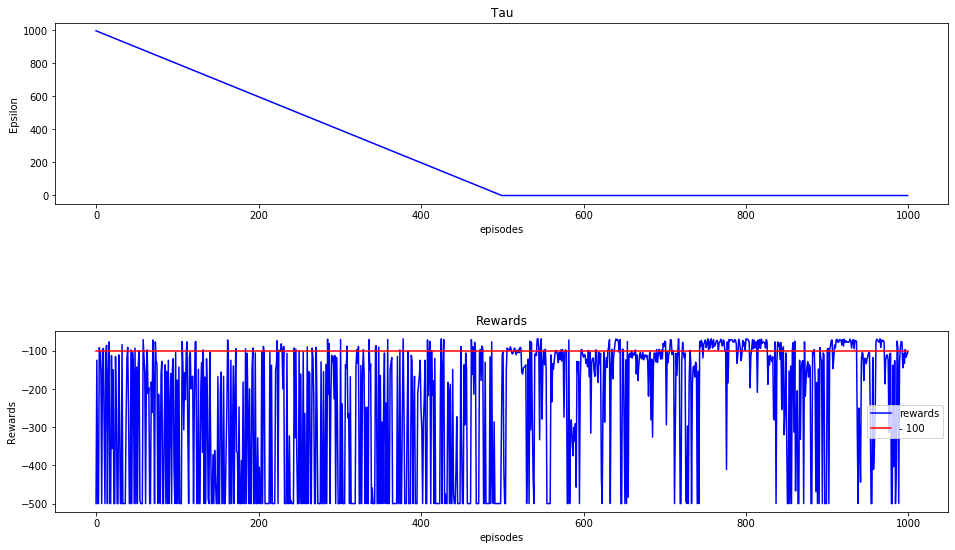

In [5]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
env = gym.make('Acrobot-v1')
import random
'''------------------------------------STATES--------------------------------------'''
#print(env.observation_space.high[0]) # 1  cos of first rotational joint 
#print(env.observation_space.high[1])  # 1 sin of first rotational joint
#print(env.observation_space.high[2])  # 1 cos of first rotational joint
#print(env.observation_space.high[3])  # 1 sin of first rotational joint
#print(env.observation_space.high[4])  # 12.566371 angular velocity of 1st joint
#print(env.observation_space.high[5])  # 28.274334 angular velocity of 2nd joint

#print('states low value:')
#print(env.observation_space.low[0])   #-4.8
#print(env.observation_space.low[1])  #-3.4028235e+38
#print(env.observation_space.low[2])  #-0.41887903
#print(env.observation_space.low[3])  #-3.4028235e+38
#print(env.observation_space.low[4])
#print(env.observation_space.low[5])
#[cos(theta1), sin(theta1), cos(theta2), sin(theta2), theta_dot1, theta_dot2]


class Qlearning():  #change the buckets #(self,bins=(1, 1, 1, 1, 12, 24) #(1,1,3,3,6,12) #(2, 2, 2, 2, 8, 12), (1, 1, 1, 1, 6, 11)
    def __init__(self,bins=(1, 1, 1, 1, 6, 13), max_episodes = 2000, max_steps = 500, min_alpha=0.1, min_epsilon=0.01, gamma = 1.0, epsilon = 1.0, decay = 25, action_space = env.action_space.n, env = gym.make('Acrobot-v1')):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> scale theta and theta' to the intervals (0,6) and (0,12) respectively 
        #rather than 3 buckets for x and xdot, making it 1 makes it so that the state space dimentionalty is signifigantly reduced 
        #Since we assign only one bucket to the cart position and velocity, it means that we ignore these 2 values.
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.min_alpha = min_alpha  #step size
        self.min_epsilon = min_epsilon #
        self.epsilon = epsilon
        self.gamma = gamma  # discount factor
        self.decay = decay
        self.action_space = action_space
        self.env = env
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q LookUp Table --> its dimension is  (1 x 1 x 1 x 1 x 6 x 13 x 3)
        self.alpha = 1 # learning rate
        self.beta = 0.5
        self.actions = None
        self.tau = 1000   
        self.tau_decay = True
        self.decay_factor_tau = 1.0

    def discretize(self, state):
        upper_bounds = [1.0, 1.0, 1.0, 1.0, env.observation_space.high[4], env.observation_space.high[5]]  
        lower_bounds = [-1.0,-1.0,-1.0,-1.0, env.observation_space.low[4], env.observation_space.low[5]]
        descretizedList = list()
        for i in  range(len(state)): 
            ratios = (state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i])
            new_obs = int(round((self.bins[i] - 1) * ratios))
            new_obs = min(self.bins[i] - 1, max(0, new_obs))
            descretizedList.append(new_obs)
        return tuple(descretizedList)


    def Boltzmann(self, state, tau):
        qList = self.QTable[state] 
        self.actions = [i for i in range(0, env.action_space.n)]
        if self.tau > 0.0:
            action_probs_numes = []
            denom = 0
            for q in qList:
                val = math.exp(q / self.tau)
                action_probs_numes.append(val)
                denom += val 
            action_probs = []
            for x in action_probs_numes:
                probs = x / denom 
                action_probs.append(probs)    
            prob_sum = 0
            action = random.choices(self.actions, weights=action_probs, k=1)[0] # the weights give a weight to correspond 
        else:
            action = np.argmax(self.QTable[state])
        return action
    def action_policy(self, state, policy):
        return policy[state]

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        return
    
    def decay_tau(self, t):          
        if self.tau_decay is True:
            #print(t)
            new_tau = self.tau - self.decay_factor_tau
        if new_tau < 0.0:
            self.tau = 0.0
        else:
            self.tau = new_tau
        return new_tau

    def decay_step_size(self, t):
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = self.alpha / (t ** self.beta)  
        return step_size

    def learning(self):
        rewards = []
        alphaList = []
        taus = []
        times = 0
        listof50 = deque(maxlen=50)
        for e in range(self.max_episodes):  
            state = self.discretize(self.env.reset())
            tau = self.decay_tau(e)
            step_size = 1 #self.decay_step_size(e)
            i = 0
            for t in range(self.max_steps):
                step_size = self.decay_step_size(t)
                if e%2==0:
                    action = self.Boltzmann(state, tau) #, epsi
                elif e%2==1:
                    action = self.action_policy(state, policy)
                new_state, reward, done, info = self.env.step(action)
                new_state = self.discretize(new_state)
                self.Q_Update(state, action, reward, new_state, step_size)
                state = new_state
                i += reward 
                if done:
                    break
            stateTuple = list()
            stateList = []
            actionsList = []
            states = []
            for list1 in self.QTable:
                for nextList in list1:
                    for nextList1 in nextList:
                        for nextList2 in nextList1:
                            for nextList3 in nextList2:
                                for nextList4 in nextList3:
                                    actions = np.argmax(nextList4)
                                    actionsList.append(actions)
            observations = np.argwhere(self.QTable >= -10000)
            for obsList in observations:
                #print(obsList)
                stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3], obsList[4], obsList[5])
                stateList.append(stateTuple)
            #break
            del stateList[1::3]
            del stateList[1::2]
            policy = dict(zip(stateList, actionsList))
            #print(policy)
            if e%2 ==1:
                rewards.append(i)
                alphaList.append(step_size)
                taus.append(tau)
                listof50.append(i)
                mean_listof50 = np.mean(listof50)
                if i >= -100:
                    times+=1
        print("Times over -100:", times)
        return rewards, alphaList, taus


if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    rewards, alpha, tau= solve.learning()
    listof_100 = []
    for episode in rewards:
        listof_100.append(-1*100)
    fig = plt.figure(figsize=(16,9)) #(14, 5)
    plt1 = fig.add_subplot(211)
    plt1.plot(tau,  
             color='b',
             label='Epsilon')
    plt1.set(title='Tau',
            ylabel='Epsilon',
            xlabel='episodes')
    """plt2 = fig.add_subplot(312)
    plt2.plot(alpha,  # epsilon_hist,
             color='b',
             label='Alpha')
    plt2.set(title='Step Size',
            ylabel='Alpha',
            xlabel='episodes')"""
    plt3 = fig.add_subplot(212)
    plt3.plot(rewards, 
             color='b',
             label='rewards')
    plt3.plot(listof_100,
             color = 'red',
             label = "- 100")
    plt3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')
    fig.subplots_adjust(hspace=0.7)
    #plt1.legend(loc='best')
    #plt2.legend(loc='best')
    plt.legend(loc='best')

    plt.show()

In [ ]:
# Constant

Times over -100: 419


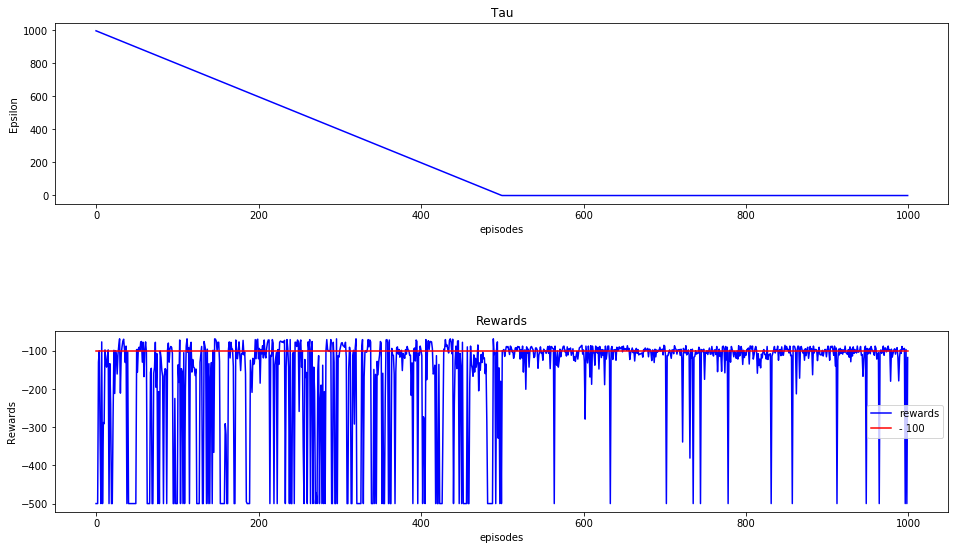

In [6]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
env = gym.make('Acrobot-v1')
import random
'''------------------------------------STATES--------------------------------------'''
#print(env.observation_space.high[0]) # 1  cos of first rotational joint 
#print(env.observation_space.high[1])  # 1 sin of first rotational joint
#print(env.observation_space.high[2])  # 1 cos of first rotational joint
#print(env.observation_space.high[3])  # 1 sin of first rotational joint
#print(env.observation_space.high[4])  # 12.566371 angular velocity of 1st joint
#print(env.observation_space.high[5])  # 28.274334 angular velocity of 2nd joint

#print('states low value:')
#print(env.observation_space.low[0])   #-4.8
#print(env.observation_space.low[1])  #-3.4028235e+38
#print(env.observation_space.low[2])  #-0.41887903
#print(env.observation_space.low[3])  #-3.4028235e+38
#print(env.observation_space.low[4])
#print(env.observation_space.low[5])
#[cos(theta1), sin(theta1), cos(theta2), sin(theta2), theta_dot1, theta_dot2]


class Qlearning():  #change the buckets #(self,bins=(1, 1, 1, 1, 12, 24) #(1,1,3,3,6,12) #(2, 2, 2, 2, 8, 12), (1, 1, 1, 1, 6, 11)
    def __init__(self,bins=(1, 1, 1, 1, 6, 13), max_episodes = 2000, max_steps = 500, min_alpha=0.1, min_epsilon=0.01, gamma = 1.0, epsilon = 1.0, decay = 25, action_space = env.action_space.n, env = gym.make('Acrobot-v1')):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> scale theta and theta' to the intervals (0,6) and (0,12) respectively 
        #rather than 3 buckets for x and xdot, making it 1 makes it so that the state space dimentionalty is signifigantly reduced 
        #Since we assign only one bucket to the cart position and velocity, it means that we ignore these 2 values.
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.min_alpha = min_alpha  #step size
        self.min_epsilon = min_epsilon #
        self.epsilon = epsilon
        self.gamma = gamma  # discount factor
        self.decay = decay
        self.action_space = action_space
        self.env = env
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q LookUp Table --> its dimension is  (1 x 1 x 1 x 1 x 6 x 13 x 3)
        self.alpha = 1 # learning rate
        self.beta = 0.5
        self.actions = None
        self.tau = 1000   
        self.tau_decay = True
        self.decay_factor_tau = 1.0

    def discretize(self, state):
        upper_bounds = [1.0, 1.0, 1.0, 1.0, env.observation_space.high[4], env.observation_space.high[5]]  
        lower_bounds = [-1.0,-1.0,-1.0,-1.0, env.observation_space.low[4], env.observation_space.low[5]]
        descretizedList = list()
        for i in  range(len(state)): 
            ratios = (state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i])
            new_obs = int(round((self.bins[i] - 1) * ratios))
            new_obs = min(self.bins[i] - 1, max(0, new_obs))
            descretizedList.append(new_obs)
        return tuple(descretizedList)


    def Boltzmann(self, state, tau):
        qList = self.QTable[state] 
        self.actions = [i for i in range(0, env.action_space.n)]
        if self.tau > 0.0:
            action_probs_numes = []
            denom = 0
            for q in qList:
                val = math.exp(q / self.tau)
                action_probs_numes.append(val)
                denom += val 
            action_probs = []
            for x in action_probs_numes:
                probs = x / denom 
                action_probs.append(probs)    
            prob_sum = 0
            action = random.choices(self.actions, weights=action_probs, k=1)[0] # the weights give a weight to correspond 
        else:
            action = np.argmax(self.QTable[state])
        return action
    def action_policy(self, state, policy):
        return policy[state]

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        return
    
    def decay_tau(self, t):          
        if self.tau_decay is True:
            #print(t)
            new_tau = self.tau - self.decay_factor_tau
        if new_tau < 0.0:
            self.tau = 0.0
        else:
            self.tau = new_tau
        return new_tau

    def decay_step_size(self, t):
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = self.alpha / (t ** self.beta)  
        return step_size

    def learning(self):
        rewards = []
        alphaList = []
        taus = []
        times = 0
        listof50 = deque(maxlen=50)
        for e in range(self.max_episodes):  
            state = self.discretize(self.env.reset())
            tau = self.decay_tau(e)
            step_size = 0.01 #self.decay_step_size(e)
            i = 0
            for t in range(self.max_steps):
                #step_size = self.decay_step_size(t)
                if e%2==0:
                    action = self.Boltzmann(state, tau) #, epsi
                elif e%2==1:
                    action = self.action_policy(state, policy)
                new_state, reward, done, info = self.env.step(action)
                new_state = self.discretize(new_state)
                self.Q_Update(state, action, reward, new_state, step_size)
                state = new_state
                i += reward 
                if done:
                    break
            stateTuple = list()
            stateList = []
            actionsList = []
            states = []
            for list1 in self.QTable:
                for nextList in list1:
                    for nextList1 in nextList:
                        for nextList2 in nextList1:
                            for nextList3 in nextList2:
                                for nextList4 in nextList3:
                                    actions = np.argmax(nextList4)
                                    actionsList.append(actions)
            observations = np.argwhere(self.QTable >= -10000)
            for obsList in observations:
                #print(obsList)
                stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3], obsList[4], obsList[5])
                stateList.append(stateTuple)
            #break
            del stateList[1::3]
            del stateList[1::2]
            policy = dict(zip(stateList, actionsList))
            #print(policy)
            if e%2 ==1:
                rewards.append(i)
                alphaList.append(step_size)
                taus.append(tau)
                listof50.append(i)
                mean_listof50 = np.mean(listof50)
                if i >= -100:
                    times+=1
        print("Times over -100:", times)
        return rewards, alphaList, taus


if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    rewards, alpha, tau= solve.learning()
    listof_100 = []
    for episode in rewards:
        listof_100.append(-1*100)
    fig = plt.figure(figsize=(16,9)) #(14, 5)
    plt1 = fig.add_subplot(211)
    plt1.plot(tau,  
             color='b',
             label='Epsilon')
    plt1.set(title='Tau',
            ylabel='Epsilon',
            xlabel='episodes')
    """plt2 = fig.add_subplot(312)
    plt2.plot(alpha,  # epsilon_hist,
             color='b',
             label='Alpha')
    plt2.set(title='Step Size',
            ylabel='Alpha',
            xlabel='episodes')"""
    plt3 = fig.add_subplot(212)
    plt3.plot(rewards, 
             color='b',
             label='rewards')
    plt3.plot(listof_100,
             color = 'red',
             label = "- 100")
    plt3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')
    fig.subplots_adjust(hspace=0.7)
    #plt1.legend(loc='best')
    #plt2.legend(loc='best')
    plt.legend(loc='best')

    plt.show()